In [107]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
DATA_DIR = "/mnt/ernie_main/Ghassan/ephys/data/periconnectivity"
peri_fs = glob.glob(os.path.join(DATA_DIR, "*pat*.csv"))



In [109]:
print(f"loading file: {peri_fs[-5]}")
tst = pd.read_csv(peri_fs[-1])


loading file: /mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Spat49.csv


In [110]:
len(peri_fs)

75

In [111]:
grp_peri_dfs = []
check_list = []
for f in peri_fs:
    if "Spat18" in f or "Spat17" in f or "Epat20" in f:
        continue
    peri_df = pd.read_csv(f)
    try:
        peri_event_df = center_onset(peri_df)
        grp_peri_dfs.append(peri_event_df)
    except IndexError as e:
        print(f) 
        check_list.append(f)
grp_peri_dfs = pd.concat(grp_peri_dfs)

/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df = peri_df[peri_df.eventID == event]
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:608: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:609: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [112]:
print(f"Successfully loaded {len(set(grp_peri_dfs.patID))} patients records")
check_list

Successfully loaded 75 patients records


[]

In [113]:
set(grp_peri_dfs[grp_peri_dfs.patID=='Epat02'].eventID)

{3, 4, 5, 6, 7, 8, 9, 10, 11}

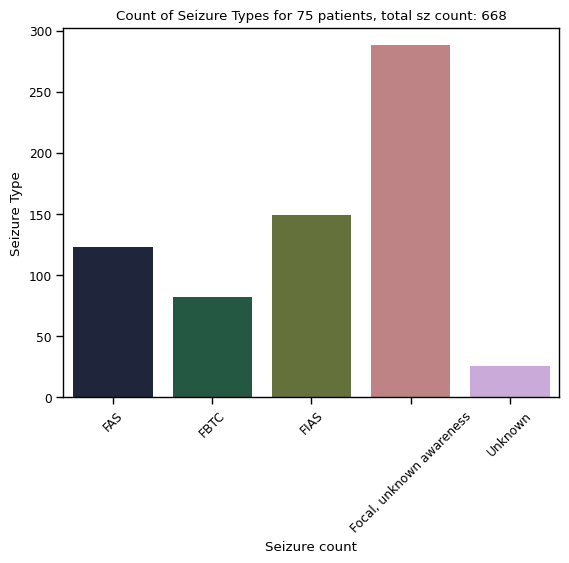

In [114]:
tmp_df = grp_peri_dfs[grp_peri_dfs.period ==0]
tmp_df  =tmp_df[tmp_df.region == 'soz']
tmp_df = tmp_df[tmp_df.freq_band == 'delta']
count_df = tmp_df[['eventID','patID','sz_type']].groupby(['sz_type']).count().reset_index()
total_sz = count_df.eventID.sum()
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        ax = sns.barplot(count_df, x='sz_type', y='eventID', hue="sz_type")
        _ = plt.xticks(rotation=45)
        _ = plt.title(f"Count of Seizure Types for 75 patients, total sz count: {total_sz}")
        plt.xlabel("Seizure count")
        plt.ylabel("Seizure Type")
        plt.savefig("../viz/sz_counts.svg", format='svg', dpi=600, transparent=True)



# Visualizing seizure-centered connectivity dynamics

In [115]:
grp_peri_dfs

,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,eventID,patID,sz_type,win_sz_centered,sz_end,win_sz_st_end,win_label
46764,0,soz,0.027119,0.093737,0.066619,delta,0.0_0.0_0.0,3,Epat02,FBTC,-595.0,108.0,-595.0,interictal
46765,0,nz,-0.000810,0.070555,0.071365,delta,0.0_0.0_0.0,3,Epat02,FBTC,-595.0,108.0,-595.0,interictal
46766,0,soz,0.025991,0.102147,0.076156,theta,0.0_0.0_0.0,3,Epat02,FBTC,-595.0,108.0,-595.0,interictal
46767,0,nz,-0.000776,0.074854,0.075630,theta,0.0_0.0_0.0,3,Epat02,FBTC,-595.0,108.0,-595.0,interictal
46768,0,soz,0.035589,0.111655,0.076066,alpha,0.0_0.0_0.0,3,Epat02,FBTC,-595.0,108.0,-595.0,interictal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31591,1324,nz,0.000016,0.066600,0.066584,beta,2.0_2.0_2.0,2,Spat53,FBTC,729.0,135.0,622.0,post_ictal
31592,1324,soz,0.002851,0.065359,0.062508,gamma_l,2.0_2.0_2.0,2,Spat53,FBTC,729.0,135.0,622.0,post_ictal
31593,1324,nz,-0.000034,0.066091,0.066125,gamma_l,2.0_2.0_2.0,2,Spat53,FBTC,729.0,135.0,622.0,post_ictal
31594,1324,soz,-0.000967,0.070340,0.071307,gamma_H,2.0_2.0_2.0,2,Spat53,FBTC,729.0,135.0,622.0,post_ictal


In [116]:
#Grouping across seizures on a per-patient level
# For every patient, along each region, in each frequency band, for all windows of time per seizure, group and get average values
tmp_df = grp_peri_dfs.dropna()
peri_stats_df = tmp_df[['region','net_pdc','in_pdc','out_pdc','freq_band','patID','win_sz_st_end']].groupby(['patID','region','freq_band', 'win_sz_st_end',]).mean().reset_index()
peri_stats_df.shape[0]


1520412

In [117]:
peri_stats_df

,patID,region,freq_band,win_sz_st_end,net_pdc,in_pdc,out_pdc
0,Epat02,nz,alpha,-595.0,-0.001985,0.072466,0.074450
1,Epat02,nz,alpha,-594.0,-0.002078,0.071453,0.073530
2,Epat02,nz,alpha,-593.0,-0.002462,0.070521,0.072983
3,Epat02,nz,alpha,-592.0,-0.002188,0.071400,0.073589
4,Epat02,nz,alpha,-591.0,-0.001999,0.070762,0.072761
...,...,...,...,...,...,...,...
1520407,pat33,soz,theta,619.0,-0.000926,0.082692,0.083618
1520408,pat33,soz,theta,620.0,-0.002262,0.083665,0.085926
1520409,pat33,soz,theta,621.0,-0.009291,0.074645,0.083937
1520410,pat33,soz,theta,622.0,-0.013951,0.072629,0.086580


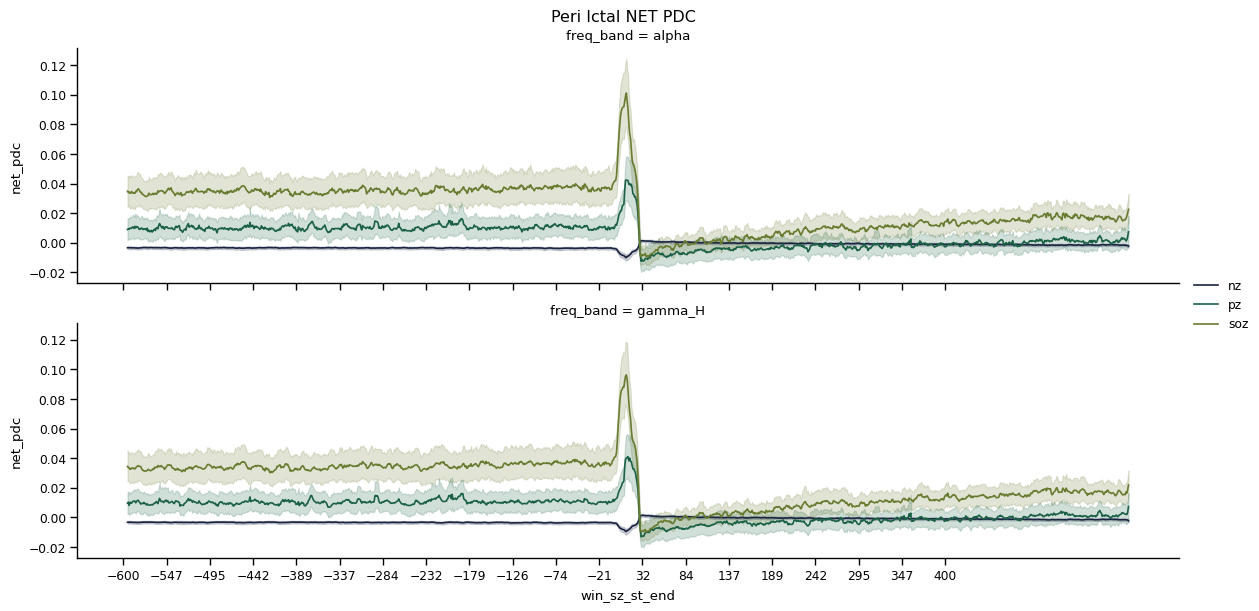

In [119]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        plot_df = peri_stats_df#[peri_stats_df.win_sz_st_end >399]
        # plot_df = plot_df[plot_df.win_sz_st_end>-100]
        grid = sns.FacetGrid(plot_df, row='freq_band',row_order=['alpha','gamma_H'],aspect=4) 
        ax = grid.map_dataframe(sns.lineplot, y='net_pdc',x='win_sz_st_end', hue='region')
        # ax.set(ylim=(-3, 20))
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal NET PDC",y=1.01)
        plt.xticks(np.linspace(-600,400,20))
        plt.savefig("../viz/peri_Epat_FULL_peri_NETpdc_noNORM.pdf", format='pdf', transparent=True)


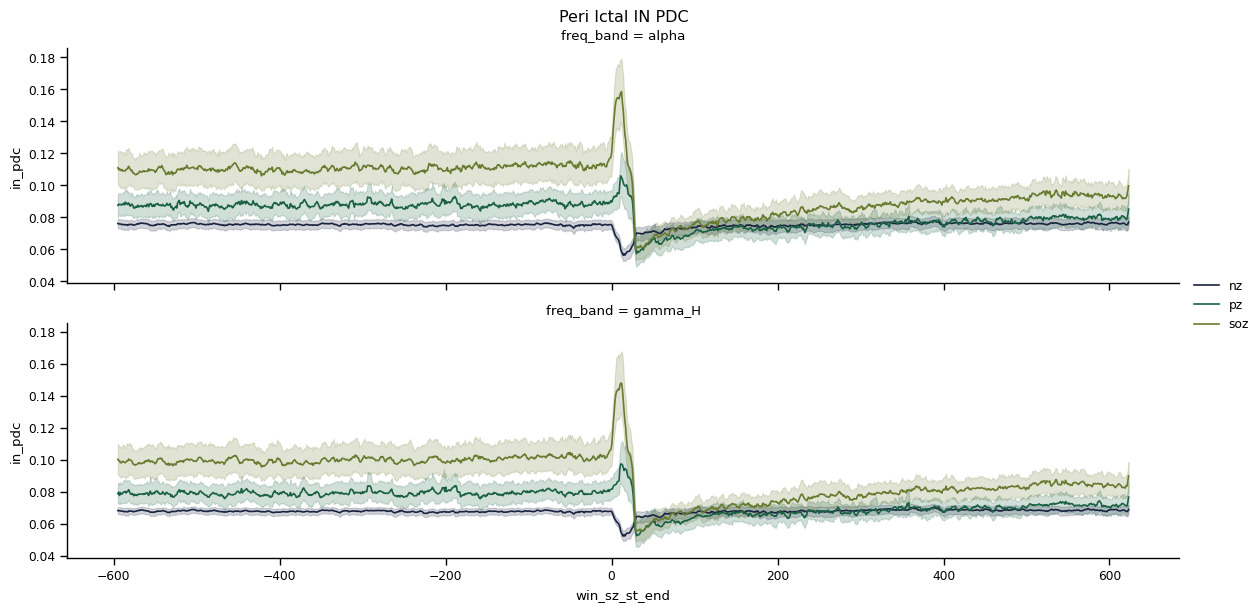

In [120]:
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        grid = sns.FacetGrid(peri_stats_df, row='freq_band',row_order=['alpha','gamma_H'],aspect=4) 
        grid.map_dataframe(sns.lineplot, y='in_pdc',x='win_sz_st_end', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal IN PDC",y=1.01)
        plt.savefig("../viz/peri_Epat_FULL_peri_INpdc_noNORM.pdf",transparent=True)


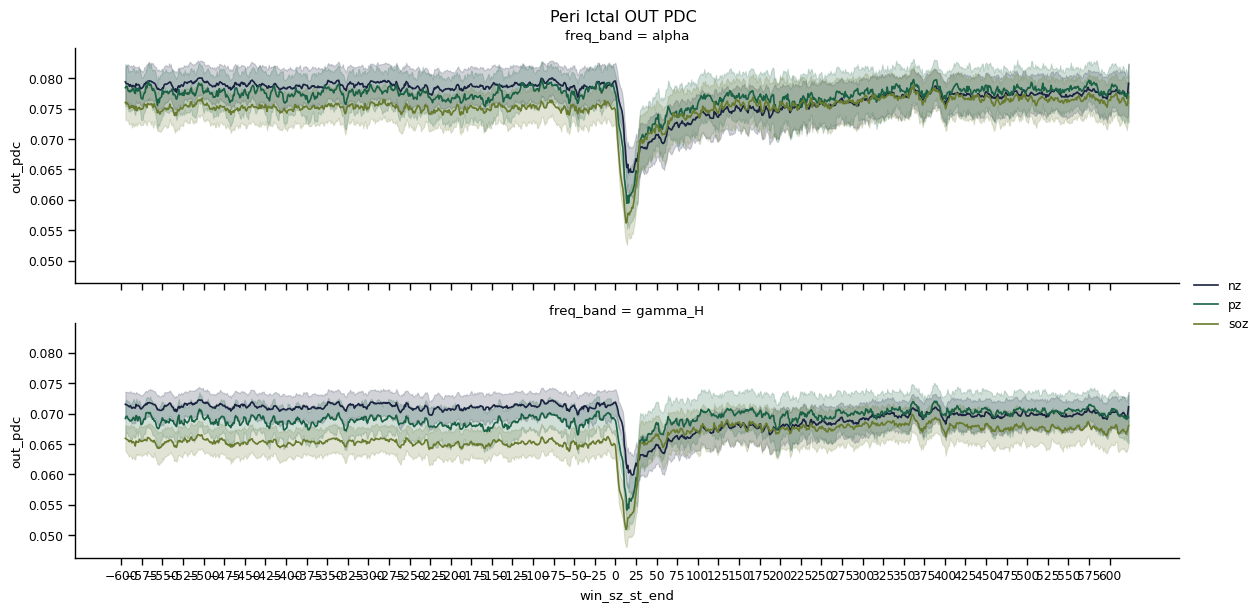

In [121]:
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        grid = sns.FacetGrid(peri_stats_df, row='freq_band',row_order=['alpha','gamma_H'],aspect=4) 
        grid.map_dataframe(sns.lineplot, y='out_pdc',x='win_sz_st_end', hue='region')
        grid.add_legend()
        plt.xticks(np.linspace(-600,600,49))

        grid.figure.suptitle("Peri Ictal OUT PDC",y=1.01)
        plt.savefig("../viz/peri_Epat_FULL_peri_OUTpdc_zscore_noNORM.pdf",transparent=True)


TODO:
1. Zoom in on Pre-ictal Period, is anything significantly different during this period?
1. Compress timelines
1. Add significance testing for periods 

## Zooming in On the Pre-ictal Period

In [51]:
tmp_df = grp_peri_dfs[grp_peri_dfs.win_sz_st_end < -10]
tmp_df = tmp_df[tmp_df.win_label.isin(['interictal','pre_ictal','early_ictal', 'early_post_ictal'])].dropna()
peri_stats_df = tmp_df[['region','net_pdc','in_pdc','out_pdc','freq_band','patID','win_sz_st_end']].groupby(['patID','region','freq_band', 'win_sz_st_end']).mean().reset_index()


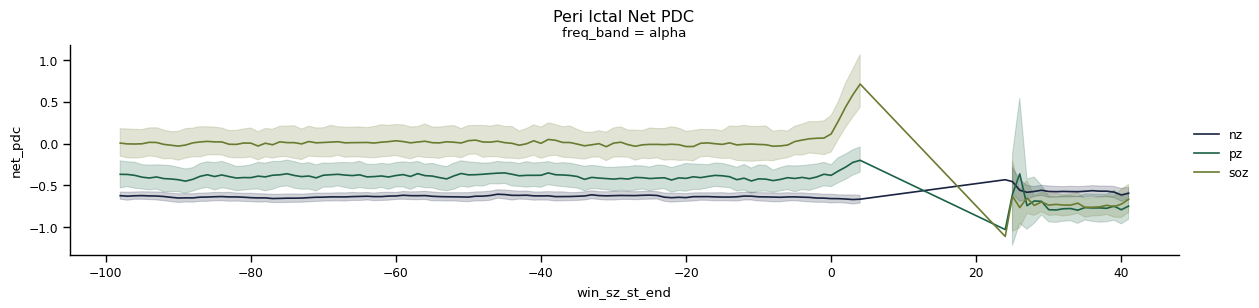

In [55]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        plot_df = peri_stats_df[peri_stats_df.win_sz_st_end >-99]
        # plot_df = plot_df[plot_df.win_sz_st_end>-100]
        grid = sns.FacetGrid(plot_df, row='freq_band',row_order=['alpha'],aspect=4) 
        ax = grid.map_dataframe(sns.lineplot, y='net_pdc',x='win_sz_st_end', hue='region')
        # ax.set(ylim=(-3, 20))
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal Net PDC",y=1.01)
        #plt.xticks(np.linspace(-600,400,3))


In [105]:
tmp_df = grp_peri_dfs[grp_peri_dfs.win_sz_st_end  < 30].dropna()
window_stats_df = tmp_df[['region','net_pdc','in_pdc','out_pdc','freq_band','patID','win_label']].groupby(['patID','region','freq_band', 'win_label']).mean().reset_index()
window_stats_df = window_stats_df.melt(id_vars=['patID','region','freq_band','win_label',], value_vars=['net_pdc','in_pdc','out_pdc'],value_name='strength', var_name='connectivity')
window_stats_df.head()
set(window_stats_df.win_label)

{'early_ictal',
 'early_post_ictal',
 'ictal',
 'interictal',
 'late_ictal',
 'pre_ictal'}

In [94]:
window_stats_df

,patID,region,freq_band,win_label,connectivity,strength
0,Epat02,nz,alpha,early_ictal,net_pdc,-0.909632
1,Epat02,nz,alpha,ictal,net_pdc,-0.747132
2,Epat02,nz,alpha,interictal,net_pdc,-0.844080
3,Epat02,nz,alpha,late_ictal,net_pdc,-0.646966
4,Epat02,nz,alpha,pre_ictal,net_pdc,-0.919084
...,...,...,...,...,...,...
18679,pat33,soz,theta,early_ictal,out_pdc,1.637392
18680,pat33,soz,theta,ictal,out_pdc,1.129956
18681,pat33,soz,theta,interictal,out_pdc,1.708764
18682,pat33,soz,theta,late_ictal,out_pdc,0.554712


In [104]:
# tmp_df = window_stats_df[window_stats_df.freq_band == 'gamma_H']
# tmp_df[['region','freq_band','connectivity', 'win_label','strength']].groupby(['region','freq_band','connectivity', 'win_label']).mean()

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and w

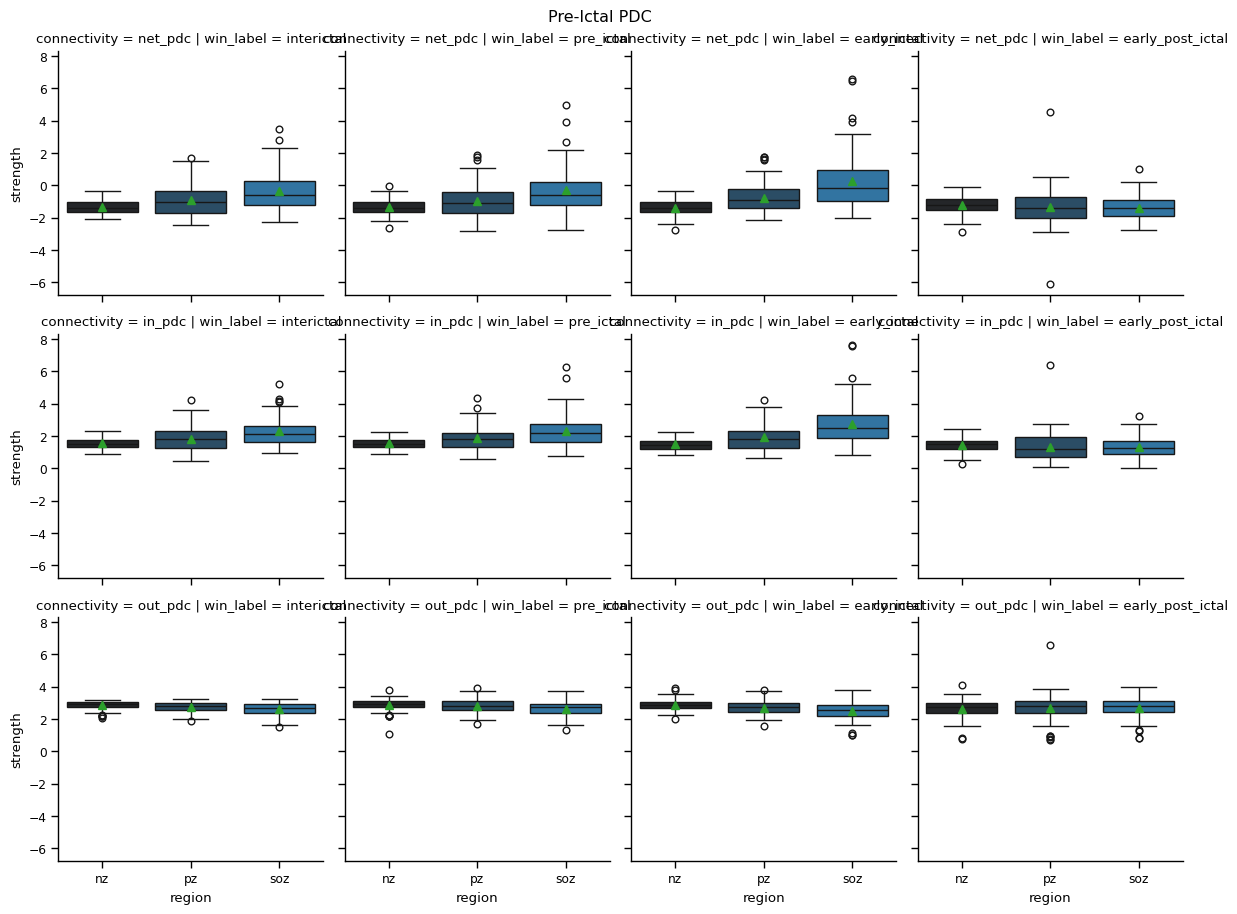

In [106]:
with sns.plotting_context("paper"):
        plot_df = window_stats_df[window_stats_df.freq_band =='gamma_H']
        grid = sns.FacetGrid(plot_df, row='connectivity',row_order=['net_pdc', 'in_pdc','out_pdc'],col='win_label', col_order=['interictal','pre_ictal','early_ictal', 'early_post_ictal']) 
        ax = grid.map_dataframe(sns.boxplot, y='strength',x='region', hue='region', showmeans=True)
        grid.add_legend()
        grid.figure.suptitle("Pre-Ictal PDC",y=1.01)
